In [1]:
from collections import defaultdict
import re
import math
import statistics
from typing import Tuple


In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from rouge import Rouge
import torch

In [3]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

In [4]:
from gensim.summarization import summarize as gensim_summarize

In [5]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.kl import KLSummarizer

In [6]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelWithLMHead, AutoModelForSeq2SeqLM, AutoModelForMaskedLM


2022-06-04 18:37:57.855550: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-04 18:37:57.861824: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-04 18:37:57.861844: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
dataset = load_dataset('cnn_dailymail', '3.0.0', split='test')[:10]

Reusing dataset cnn_dailymail (/home/vien/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


In [8]:
class TFIDFSummarizer:
    def __init__(self):
        self.stop_words = set(stopwords.words("english"))

    def sent_clean(self, sentence) -> str:
        # Convert to lowercase
        clean_sent = sentence.lower()
        # Remove all the special characters
        clean_sent = re.sub(r"[^a-zA-Z0-9\s]", "", clean_sent)
        # Remove all the digits
        clean_sent = re.sub(r"\d+", "", clean_sent)
        # Remove all single-character words
        clean_sent = re.sub(r"\b\w\b", "", clean_sent)
        return clean_sent

    def words_clean(self, words) -> list:
        ps = PorterStemmer()
        clean_words = [ps.stem(w) for w in words if w not in self.stop_words]
        for word in words:
            if word in self.stop_words:
                continue
            clean_words.append(word)
        return clean_words

    def sent_word_freqs(self, sentences) -> dict:
        sent_word_freqs = dict()
        for sentence in sentences:
            clean_sent = self.sent_clean(sentence)
            word_freqs = defaultdict(int)
            words = word_tokenize(clean_sent, language="english")
            clean_words = self.words_clean(words)
            for word in clean_words:
                word_freqs[word] += 1
            sent_word_freqs[sentence] = word_freqs
        return sent_word_freqs

    def tf_scores(self, sent_word_freqs) -> dict:
        tf_scores = defaultdict(lambda: dict())
        for sent, word_freqs in sent_word_freqs.items():
            for word, freq in word_freqs.items():
                tf_scores[sent][word] = freq / len(sent)
        return tf_scores

    def word_sent_freqs(self, sent_word_freqs) -> dict:
        word_sent_freqs = defaultdict(int)
        for _, word_freqs in sent_word_freqs.items():
            for word, _ in word_freqs.items():
                word_sent_freqs[word] += 1
        return word_sent_freqs

    def idf_scores(self, sentences, word_sent_freqs, smooth=True) -> dict:
        idf_scores = defaultdict(int)
        for word in word_sent_freqs:
            if smooth:
                # Prevent division by zero
                idf_scores[word] = (
                    math.log10((1 + len(sentences)) / (1 + float(word_sent_freqs[word]))) + 1
                )
            else:
                idf_scores[word] = math.log10(len(sentences) / float(word_sent_freqs[word]))
        return idf_scores

    def word_tfidf(self, tf, idf) -> float:
        return tf * idf

    def sent_tfidf(self, sentence, tf_scores, idf_scores) -> float:
        sent_tfidf = 0
        clean_sent = self.sent_clean(sentence)
        words = word_tokenize(clean_sent, language="english")
        clean_words = self.words_clean(words)
        for word in clean_words:
            sent_tfidf += self.word_tfidf(tf_scores[sentence][word], idf_scores[word])
        return sent_tfidf

    def sent_scores(self, sentences) -> dict:
        # Compute word frequencies for each sentence
        sent_word_freqs = self.sent_word_freqs(sentences)
        # Compute TF scores for each word
        tf_scores = self.tf_scores(sent_word_freqs)

        # Compute document (sentence) frequencies for each word
        word_sent_freqs = self.word_sent_freqs(sent_word_freqs)
        # Compute IDF scores for each word
        idf_scores = self.idf_scores(sentences, word_sent_freqs)

        sent_scores = dict()
        for sentence in sentences:
            sent_scores[sentence] = self.sent_tfidf(sentence, tf_scores, idf_scores)
        return sent_scores

    def summarize(self, text, n=0) -> str:
        # Sentence tokenize the original text
        sentences = sent_tokenize(text)
        # Compute TFIDF scores for each sentence
        sent_scores = self.sent_scores(sentences)
        # Generate the summary
        sorted_sent_scores = sorted(
            sent_scores.items(), key=lambda x: x[1], reverse=True
        )
        # If n not specified return the sentences with scores above 1-stdev from the mean
        if n <= 0:
            mean = statistics.mean(sent_scores.values())
            stdev = statistics.stdev(sent_scores.values())
            summary = " ".join([s for s in sentences if sent_scores[s] >= mean + stdev])
            # # If not successful, return most important sentence
            # if len(summary) == 0:
            #     n = 1
        # If n specified or still no summary, return the top n sentences as summary
        if n > 0:
            top_n_sentences = [s[0] for s in sorted_sent_scores[:n]]
            summary = " ".join([s for s in sentences if s in top_n_sentences])
        return summary


In [9]:
def filter_empty_summaries(hyps, refs) -> Tuple[list, list]:
    hyps_and_refs = zip(hyps, refs)
    hyps_and_refs = [_ for _ in hyps_and_refs if len(_[0]) > 0]
    new_hyps, new_refs = zip(*hyps_and_refs)
    return list(new_hyps), list(new_refs)

def text_clean(text) -> str:
    summarizer = TFIDFSummarizer()
    sentences = sent_tokenize(text)
    clean_sent_words = []
    for sentence in sentences:
        clean_sent = summarizer.sent_clean(sentence)
        words = word_tokenize(clean_sent, language="english")
        clean_words = summarizer.words_clean(words)
        clean_sent_words.append(clean_words)

In [10]:
def summarize_with_summarizer(summarizer, parser=None, params="") -> Tuple[list, list]:
    refs = []
    hyps = []
    if params:
        params_str = f", {params}"
    document_str = "parser.document" if parser else "text"
    for i in tqdm(range(len(dataset["id"]))):
        text = dataset["article"][i]
        target = dataset["highlights"][i]
        refs.append(target)
        if parser:
            parser = PlaintextParser.from_string(text, Tokenizer("english"))
        actual = eval(f"summarizer({document_str}{params_str})")
        hyps.append(str(actual))
    hyps, refs = filter_empty_summaries(hyps, refs)
    return hyps, refs


def summarize_with_transformer(model, tokenizer, isT5=False) -> Tuple[list, list]:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    refs = dataset["highlights"]
    hyps = []
    for i in tqdm(range(len(dataset["id"]))):
        text = dataset["article"][i]
        if isT5:
            text = f"summarize:{text}"
            input_ids = tokenizer.encode(
                text, return_tensors="pt", max_length=512, truncation="longest_first"
            ).to(device)
            summary_ids = model.generate(input_ids)
            summary = tokenizer.decode(summary_ids[0], max_length=512)
        else:
            inputs = tokenizer.batch_encode_plus(
                [text], return_tensors="pt", max_length=512, truncation="longest_first"
            ).to(device)
            summary_ids = model.generate(inputs["input_ids"], early_stopping=True)
            summary = tokenizer.decode(
                summary_ids[0], skip_special_tokens=True, max_length=512
            )
        hyps.append(str(summary))
    hyps, refs = filter_empty_summaries(hyps, refs)
    return hyps, refs


In [11]:
def add_scores(rouge_scores, new_summarizer, new_scores):
    rouge_scores["summarizer"].append(new_summarizer)
    rouge_scores["rouge-1"].append(new_scores["rouge-1"]["f"])
    rouge_scores["rouge-2"].append(new_scores["rouge-2"]["f"])
    rouge_scores["rouge-l"].append(new_scores["rouge-l"]["f"])

In [12]:
rouge = Rouge()
rouge_scores = {"summarizer": [], "rouge-1": [], "rouge-2": [], "rouge-l": []}


In [13]:
hyps, refs = summarize_with_summarizer(
    TFIDFSummarizer().summarize, params="n=len(sent_tokenize(target))"
)
scores = rouge.get_scores(hyps, refs, avg=True)
print(scores)
add_scores(rouge_scores, "TFIDF", scores)


100%|██████████| 10/10 [00:00<00:00, 37.82it/s]

{'rouge-1': {'r': 0.15949505502446684, 'p': 0.1727702073523602, 'f': 0.16036570764806268}, 'rouge-2': {'r': 0.03918594955180321, 'p': 0.035057435254803676, 'f': 0.036471995364060185}, 'rouge-l': {'r': 0.15393949946891125, 'p': 0.1678921585718724, 'f': 0.1551709024532575}}


In [14]:
hyps, refs = summarize_with_summarizer(
    gensim_summarize, params="word_count=len(target)"
)
scores = rouge.get_scores(hyps, refs, avg=True)
print(scores)
add_scores(rouge_scores, "TextRank", scores)


100%|██████████| 10/10 [00:00<00:00, 84.83it/s]


{'rouge-1': {'r': 0.6699473705944293, 'p': 0.1478411039265784, 'f': 0.24183023473480297}, 'rouge-2': {'r': 0.27644781505757116, 'p': 0.04740967104631121, 'f': 0.0807945636398625}, 'rouge-l': {'r': 0.6212024813201285, 'p': 0.1369535485002086, 'f': 0.22406756758083204}}


In [15]:
hyps, refs = summarize_with_summarizer(
    LexRankSummarizer(), PlaintextParser.from_string, "len(sent_tokenize(target))"
)
scores = rouge.get_scores(hyps, refs, avg=True)
print(scores)
add_scores(rouge_scores, "LexRank", scores)


100%|██████████| 10/10 [00:00<00:00, 37.89it/s]

{'rouge-1': {'r': 0.31224854495442733, 'p': 0.20139576653221666, 'f': 0.24374004194707352}, 'rouge-2': {'r': 0.08828407906456688, 'p': 0.053517395530852704, 'f': 0.06639832820611627}, 'rouge-l': {'r': 0.28162634980282036, 'p': 0.1820370467485098, 'f': 0.22015901673304686}}


In [16]:
hyps, refs = summarize_with_summarizer(
    LsaSummarizer(), PlaintextParser.from_string, "len(sent_tokenize(target))"
)
scores = rouge.get_scores(hyps, refs, avg=True)
print(scores)
add_scores(rouge_scores, "LSA", scores)


100%|██████████| 10/10 [00:00<00:00, 31.85it/s]

{'rouge-1': {'r': 0.2408750874633228, 'p': 0.15475260618694486, 'f': 0.18629811296979382}, 'rouge-2': {'r': 0.036105766861864425, 'p': 0.022178333626228907, 'f': 0.02714593948877104}, 'rouge-l': {'r': 0.20196717802600156, 'p': 0.12880197745900968, 'f': 0.1554784883219603}}


In [17]:
hyps, refs = summarize_with_summarizer(
    LuhnSummarizer(), PlaintextParser.from_string, "len(sent_tokenize(target))"
)
scores = rouge.get_scores(hyps, refs, avg=True)
print(scores)
add_scores(rouge_scores, "Luhn", scores)


100%|██████████| 10/10 [00:00<00:00, 106.90it/s]

{'rouge-1': {'r': 0.38139780728016026, 'p': 0.2030788675628618, 'f': 0.2634659407877432}, 'rouge-2': {'r': 0.13316216574753162, 'p': 0.06641437706474826, 'f': 0.08828113976467925}, 'rouge-l': {'r': 0.33954473189767315, 'p': 0.1794664044036967, 'f': 0.2333997734889949}}


In [18]:
hyps, refs = summarize_with_summarizer(
    KLSummarizer(), PlaintextParser.from_string, "len(sent_tokenize(target))"
)
scores = rouge.get_scores(hyps, refs, avg=True)
print(scores)
add_scores(rouge_scores, "KL-Sum", scores)


100%|██████████| 10/10 [00:00<00:00, 25.56it/s]


{'rouge-1': {'r': 0.2823435467553114, 'p': 0.1915301177866581, 'f': 0.22675266673047934}, 'rouge-2': {'r': 0.08282164989482063, 'p': 0.05913759913146621, 'f': 0.06826242471487462}, 'rouge-l': {'r': 0.26217585805821103, 'p': 0.1774373282760789, 'f': 0.2102206055872175}}


In [19]:
model = AutoModelWithLMHead.from_pretrained("t5-small")
tokenizer = AutoTokenizer.from_pretrained("t5-small")
hyps, refs = summarize_with_transformer(model, tokenizer, isT5=True)
scores = rouge.get_scores(hyps, refs, avg=True)
print(scores)
add_scores(rouge_scores, "T5", scores)


/home/vien/College/fdl/venv/lib/python3.7/site-packages/transformers/models/auto/modeling_auto.py:925: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
/home/vien/College/fdl/venv/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5_fast.py:161: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `

{'rouge-1': {'r': 0.1476421952892541, 'p': 0.34762737262737264, 'f': 0.2038860335888672}, 'rouge-2': {'r': 0.03995734076221881, 'p': 0.10546453546453546, 'f': 0.05633235232261482}, 'rouge-l': {'r': 0.1339034565505154, 'p': 0.32048451548451545, 'f': 0.18602215726910853}}


In [20]:
model = AutoModelWithLMHead.from_pretrained("facebook/bart-large-cnn")
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
hyps, refs = summarize_with_transformer(model, tokenizer)
scores = rouge.get_scores(hyps, refs, avg=True)
print(scores)
add_scores(rouge_scores, "BART", scores)


100%|██████████| 10/10 [02:07<00:00, 12.78s/it]

{'rouge-1': {'r': 0.4286533745357275, 'p': 0.3038160825996531, 'f': 0.3497571883894518}, 'rouge-2': {'r': 0.1912339774047091, 'p': 0.12768319183761684, 'f': 0.14890984764402665}, 'rouge-l': {'r': 0.4027400326223855, 'p': 0.2861576734321438, 'f': 0.3290490622636894}}


In [21]:
model = AutoModelWithLMHead.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
hyps, refs = summarize_with_transformer(model, tokenizer)
scores = rouge.get_scores(hyps, refs, avg=True)
print(scores)
add_scores(rouge_scores, "GPT2", scores)


  0%|          | 0/10 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 512, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
 10%|█         | 1/10 [00:01<00:10,  1.16s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 506, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
 20%|██        | 2/10 [00:02<00:12,  1.56s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 512, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
 30%|███       | 3/10 [00:04<00:11,  1.65s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input

{'rouge-1': {'r': 0.7502753700988996, 'p': 0.12152004570984978, 'f': 0.2066983610364043}, 'rouge-2': {'r': 0.3473242394461907, 'p': 0.042050214709070735, 'f': 0.07411337328539111}, 'rouge-l': {'r': 0.6965770744006039, 'p': 0.11260205005974347, 'f': 0.1916416797753942}}


In [22]:
example = {
    "text": dataset["article"][0],
    "target_summary": refs[0],
    "generated_summary": hyps[0],
}

In [23]:
model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-large")
tokenizer = AutoTokenizer.from_pretrained("google/pegasus-large")
hyps, refs = summarize_with_transformer(model, tokenizer)
scores = rouge.get_scores(hyps, refs, avg=True)
print(scores)
add_scores(rouge_scores, "PEGASUS", scores)


100%|██████████| 10/10 [06:46<00:00, 40.67s/it]

{'rouge-1': {'r': 0.3294806456571163, 'p': 0.1665794569985047, 'f': 0.21221853647367586}, 'rouge-2': {'r': 0.08005998066973677, 'p': 0.0353066136282866, 'f': 0.047316280978515146}, 'rouge-l': {'r': 0.2889959141723848, 'p': 0.14565748295309994, 'f': 0.18557720223619423}}


In [24]:
model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-12-6")
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")
hyps, refs = summarize_with_transformer(model, tokenizer)
scores = rouge.get_scores(hyps, refs, avg=True)
add_scores(rouge_scores, "DistilBART", scores)


100%|██████████| 10/10 [01:29<00:00,  8.91s/it]


In [25]:
rouge_score_tuples = zip(*rouge_scores.values())
sorted_rouge_scores = sorted(rouge_score_tuples, key=lambda x: x[1])
(
    rouge_scores["summarizer"],
    rouge_scores["rouge-1"],
    rouge_scores["rouge-2"],
    rouge_scores["rouge-l"],
) = zip(*sorted_rouge_scores)


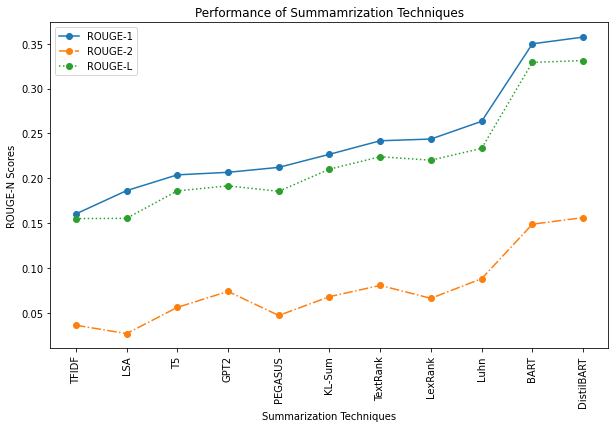

In [30]:
plt.figure(figsize=(10,6))
plt.title("Performance of Summamrization Techniques")
plt.xlabel("Summarization Techniques")
plt.ylabel("ROUGE-N Scores")
plt.xticks(rotation=90)
plt.plot(rouge_scores["summarizer"], rouge_scores["rouge-1"], "o-", label="ROUGE-1")
plt.plot(rouge_scores["summarizer"], rouge_scores["rouge-2"], "o-.", label="ROUGE-2")
plt.plot(rouge_scores["summarizer"], rouge_scores["rouge-l"], "o:", label="ROUGE-L")
plt.legend()
plt.show()
